In [27]:
import numpy as np
import networkx as nx
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

In [2]:
class TeamGame:
    def __init__(self, G, c, Ts=None):
        self.n = G.number_of_nodes()
        self.G = G
        self.c = c

        self.t = {}
        if Ts==None:
            self.Ts = {}
            for i in range(self.n):
                self.Ts[i] = [i]
                self.t[i] = i
        else:
            self.Ts = Ts
            for tid,T in Ts.items():
                for i in T:
                    self.t[i] = tid

    def gain(self,i,tid):
        ret = 0
        for j in self.Ts[tid]:
            if self.G.has_edge(i,j):
                ret += self.G[i][j]['weight']
        return ret

    def loss(self,i,tid):
        T = self.Ts[tid]
        if i in T:
            return self.c*len(T)
        else:
            return self.c*(len(T)+1)

    def utility(self,i,tid):
        return self.gain(i,tid)-self.loss(i,tid)

    def join(self,i,tid):
        pre_tid = self.t[i]
        self.Ts[pre_tid].remove(i)
        self.Ts[tid].append(i)
        self.t[i] = tid

    def LocalEquilibrium(self):
        flag = True
        i = 0
        while flag:
            flag = False
            order = list(range(self.n))
            np.random.shuffle(order)

            for i in order:
                max_tid = self.t[i]
                max_u = -np.inf
                for tid in self.Ts.keys():
                    u = self.utility(i,tid)
                    if u > max_u:
                        max_u = u
                        max_tid = tid
                if max_tid != self.t[i]:
                    flag = True
                    self.join(i,max_tid)

    def GGN(self):
        G = nx.Graph()
        G.add_nodes_from(self.G.nodes())
        for i in range(self.n):
            pre_tid = self.t[i]
            max_tid = pre_tid
            max_u = -np.inf
            for tid in self.Ts.keys():
                u = self.utility(i,tid)
                if u > max_u:
                    max_u = u
                    max_tid = tid
            
            if max_tid != pre_tid:
                for j in self.G.neighbors(i): # only keep relations in the orginal network
                    self.join(i,max_tid)
                    exp_utility = self.utility(j,self.t[j])
                    self.join(i,pre_tid)
                    real_utility = self.utility(j,self.t[j])
                    deviation = real_utility-exp_utility
                    if deviation!=0:
                        G.add_edge(i,j,weight=deviation)
        return G

In [3]:
def get_unsigned(G):
    uG = G.copy()
    uG.add_nodes_from(G.nodes)
    for i,d in G.adj.items():
        for j in d:
            uG[i][j]['weight'] = 1
    return uG

def get_A(G):
    n = G.number_of_nodes()
    A = np.zeros((n,n))
    for i,d in G.adj.items():
        for j in d:
            A[i,j] = G[i][j]['weight']
    return A

def exp_A(A,k=5):
    n = A.shape[0]
    Ai = np.eye(n)
    exp_A = np.zeros((n,n))
    for i in range(1,k+1):
        Ai = np.dot(Ai,A)
        exp_A += Ai/np.math.factorial(i)
    return exp_A

def acc(G, e_A):
    n_pos = 0
    n_neg = 0
    n_pos_err = 0
    n_neg_err = 0
    n_pass = 0
    for i,d in G.adj.items():
        for j in d:
            if e_A[i,j] == 0:
                n_pass += 1
                continue
            
            if G[i][j]['weight']>0:
                if e_A[i,j]<0:
                    n_pos_err += 1
                n_pos += 1
                
            if G[i][j]['weight']<0:
                if e_A[i,j]>0:
                    n_neg_err += 1
                n_neg += 1
    
    acc_pos = 1-n_pos_err/n_pos
    acc_neg = 1-n_neg_err/n_neg
    acc = 1-(n_pos_err+n_neg_err)/(n_pos+n_neg)
    acc_ave = (acc_pos+acc_neg)/2
    predict_rate = 1-n_pass/(n_pos+n_neg+n_pass)
    
    return (acc_pos, acc_neg, acc, acc_ave), predict_rate

In [4]:
def test(Gr, c=0.2, k=10, num_iter=1, seed=10):
    np.random.seed(seed)
    eA_total = None

    for i in range(1,num_iter+1):
        print("build team game...")
        TGr = TeamGame(Gr,c)
        print('find equilibrium...')
        TGr.LocalEquilibrium()
        RTs = TGr.Ts
    
        G = get_unsigned(Gr)
        print("build unsigned team game...")
        TG = TeamGame(G,c,RTs)
        ggn = TG.GGN()

        
        ggn_A = get_A(ggn)
        
        ks = list(range(1,k+1))
        pos_accs = []
        neg_accs = []
        tol_accs = []
        ave_accs = []
        pre_rates = []
        
        for ki in range(1,k+1):
            eA = exp_A(ggn_A,ki)
            accs,predict_rate = acc(Gr, eA)
            print(str(ki)+': ',accs,predict_rate)
        
            pos_accs.append(accs[0])
            neg_accs.append(accs[1])
            tol_accs.append(accs[2])
            ave_accs.append(accs[3])
            pre_rates.append(predict_rate)
            
        return pos_accs,neg_accs,tol_accs,ave_accs,pre_rates

## Load data

In [5]:
import pickle

In [6]:
Gs1 = pickle.load(open('data/slashdot1.pkl', 'rb'))
Gs2 = pickle.load(open('data/slashdot2.pkl', 'rb'))
Ge1 = pickle.load(open('data/epinions1.pkl', 'rb'))
Ge2 = pickle.load(open('data/epinions2.pkl', 'rb'))

## Test

In [7]:
datasets = [Gs1, Gs2, Ge1, Ge2]

In [8]:
results1 = []
for i,Gr in enumerate(datasets):
    print(i,'----------')
    results1.append(test(Gr,c=0.2, k=10, num_iter=1, seed=10))

0 ----------
build team game...
find equilibrium...
build unsigned team game...
1:  (0.5114503816793894, 1.0, 0.7477003942181341, 0.7557251908396947) 0.032556846135746165
2:  (0.8286666666666667, 0.8903002309468823, 0.8386134923592993, 0.8594834488067744) 0.11478320391880037
3:  (0.8447851599469998, 0.8560523446019629, 0.8464516129032258, 0.8504187522744813) 0.13262315771460353
4:  (0.8415597235932872, 0.8402010050251256, 0.8413685847589425, 0.8408803643092064) 0.15129735395409527
5:  (0.8342647293629251, 0.7987132352941176, 0.8290028567541832, 0.8164889823285213) 0.157244005219363
6:  (0.8207780179067614, 0.7811447811447811, 0.8146360553091573, 0.8009613995257713) 0.16398211726454037
7:  (0.8079450418160096, 0.76671974522293, 0.8014336016096579, 0.7873323935194698) 0.17009989518492374
8:  (0.7998831434414256, 0.7539742619227858, 0.7924574507162974, 0.7769287026821057) 0.17469892404115595
9:  (0.7919472703825763, 0.7476155539251651, 0.7847039079357468, 0.7697814121538706) 0.17844231962

In [9]:
results1

[([0.5114503816793894,
   0.8286666666666667,
   0.8447851599469998,
   0.8415597235932872,
   0.8342647293629251,
   0.8207780179067614,
   0.8079450418160096,
   0.7998831434414256,
   0.7919472703825763,
   0.7849675049448996],
  [1.0,
   0.8903002309468823,
   0.8560523446019629,
   0.8402010050251256,
   0.7987132352941176,
   0.7811447811447811,
   0.76671974522293,
   0.7539742619227858,
   0.7476155539251651,
   0.7383845604002859],
  [0.7477003942181341,
   0.8386134923592993,
   0.8464516129032258,
   0.8413685847589425,
   0.8290028567541832,
   0.8146360553091573,
   0.8014336016096579,
   0.7924574507162974,
   0.7847039079357468,
   0.7772796980063702],
  [0.7557251908396947,
   0.8594834488067744,
   0.8504187522744813,
   0.8408803643092064,
   0.8164889823285213,
   0.8009613995257713,
   0.7873323935194698,
   0.7769287026821057,
   0.7697814121538706,
   0.7616760326725928],
  [0.032556846135746165,
   0.11478320391880037,
   0.13262315771460353,
   0.151297353954095

In [10]:
results2 = []
for i,Gr in enumerate(datasets):
    print(i,'----------')
    results2.append(test(Gr,c=0.3, k=10, num_iter=1, seed=10))

0 ----------
build team game...
find equilibrium...
build unsigned team game...
1:  (0.4975609756097561, 1.0, 0.7401177460050463, 0.748780487804878) 0.025433699116558683
2:  (0.8273709483793518, 0.9215384615384615, 0.8400830737279336, 0.8744547049589066) 0.10299685554771221
3:  (0.8296380090497737, 0.8920118343195267, 0.8379120879120879, 0.8608249216846502) 0.1090076793086483
4:  (0.8227084119200302, 0.8793828892005611, 0.829426433915212, 0.8510456505602957) 0.1286658538150549
5:  (0.8195571955719557, 0.8528252299605782, 0.8236531305613979, 0.836191212766267) 0.13221673190870398
6:  (0.8147609525540811, 0.8430379746835444, 0.8183118741058655, 0.8288994636188127) 0.13456972341654372
7:  (0.8118971061093248, 0.8341176470588235, 0.8148263027295285, 0.8230073765840742) 0.13792808402318768
8:  (0.8051971009368923, 0.831981460023175, 0.8087423312883435, 0.8185892804800337) 0.1394682239192282
9:  (0.8043898156277436, 0.8161180476730987, 0.8059610705596107, 0.8102539316504211) 0.14066611050503

In [11]:
results2

[([0.4975609756097561,
   0.8273709483793518,
   0.8296380090497737,
   0.8227084119200302,
   0.8195571955719557,
   0.8147609525540811,
   0.8118971061093248,
   0.8051971009368923,
   0.8043898156277436,
   0.8006621362606726],
  [1.0,
   0.9215384615384615,
   0.8920118343195267,
   0.8793828892005611,
   0.8528252299605782,
   0.8430379746835444,
   0.8341176470588235,
   0.831981460023175,
   0.8161180476730987,
   0.8125701459034792],
  [0.7401177460050463,
   0.8400830737279336,
   0.8379120879120879,
   0.829426433915212,
   0.8236531305613979,
   0.8183118741058655,
   0.8148263027295285,
   0.8087423312883435,
   0.8059610705596107,
   0.8022624434389141],
  [0.748780487804878,
   0.8744547049589066,
   0.8608249216846502,
   0.8510456505602957,
   0.836191212766267,
   0.8288994636188127,
   0.8230073765840742,
   0.8185892804800337,
   0.8102539316504211,
   0.8066161410820759],
  [0.025433699116558683,
   0.10299685554771221,
   0.1090076793086483,
   0.1286658538150549,


## Plot results

In [22]:
data_names = ['Slashdot1','Slashdot2','Epinions1','Epinions2']

In [23]:
def plot_bar(rets):
    plt.figure(figsize=(5,3))
    name_list = ['Random', 'GGN']
    scores = []
    colors = list('rgmb')
    for i in range(4):
        scores.append([0.5,rets[i][3][1]])
    x =list(range(2))
    width = 0.8/4
    data_names = ['Slashdot1','Slashdot2','Epinions1','Epinions2']
    for i in range(4):
        plt.bar(x,scores[i],width=width,label=data_names[i],color=colors[i],edgecolor='black',tick_label=name_list)
        for j in range(len(x)):
            x[j]+=width
    plt.legend()
    plt.ylim(0.45,1)
    plt.ylabel('Average accuracy')
    plt.show()

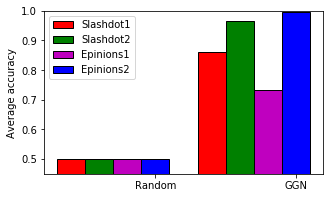

In [24]:
plot_bar(results1)

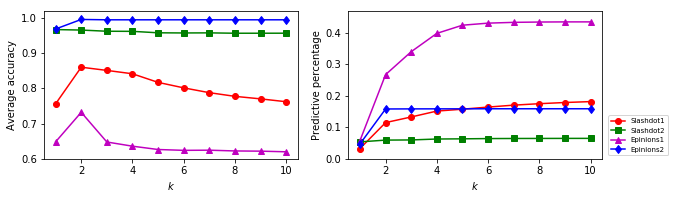

In [25]:
styles = ['-ro','-gs','-m^','-bd']
fig = plt.figure(figsize=(10,6))
# plt.subplots_adjust(wspace =0.6, hspace =0)
plt.subplot(221)
x = range(1,11)
for i in range(4):
    plt.plot(x,results1[i][3],styles[i],label=data_names[i])
plt.ylabel('Average accuracy')
plt.xlabel('$k$')
plt.ylim(0.6,1.02)

plt.subplot(222)
x = range(1,11)
for i in range(4):
    plt.plot(x,results1[i][4],styles[i],label=data_names[i])
plt.ylabel('Predictive percentage')
plt.xlabel('$k$')
plt.ylim(0,0.47)
plt.legend(bbox_to_anchor=(1.01,0),loc='lower left',prop={'size': 7})
plt.show()

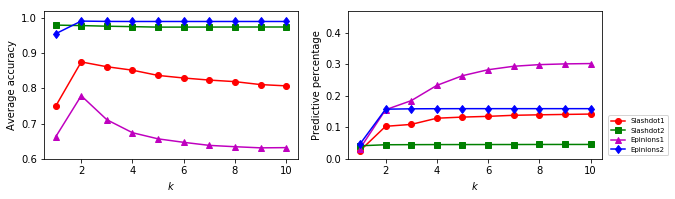

In [26]:
styles = ['-ro','-gs','-m^','-bd']
fig = plt.figure(figsize=(10,6))
plt.subplot(221)
x = range(1,11)
for i in range(4):
    plt.plot(x,results2[i][3],styles[i],label=data_names[i])
plt.ylabel('Average accuracy')
plt.xlabel('$k$')
plt.ylim(0.6,1.02)

plt.subplot(222)
x = range(1,11)
for i in range(4):
    plt.plot(x,results2[i][4],styles[i],label=data_names[i])
plt.ylabel('Predictive percentage')
plt.xlabel('$k$')
plt.ylim(0,0.47)
plt.legend(bbox_to_anchor=(1.01,0),loc='lower left',prop={'size': 7})
plt.show()